In [1]:
import os
import shutil
import subprocess
import tempfile

import dask.diagnostics
import numpy as np
import pandas as pd
import proplot
import vcm.fv3
import xarray as xr

import cloud
import plotting

In [2]:
plotting.configure_style()

In [3]:
IMAGE = "us.gcr.io/vcm-ml/post_process_run:latest"
DOCKER_IN = "/tmp/data"
DOCKER_OUT = "/tmp/data.nc"
FREGRID = "fregrid_cubed_to_latlon.sh"

BASELINE = "gs://vcm-ml-experiments/spencerc/2022-01-22/n2f-25km-baseline-unperturbed-snoalb/fv3gfs_run"
FINE_RESOLUTION = "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/unperturbed/C384-to-C48-diagnostics"
ERA5 = "gs://vcm-ml-experiments/spencerc/2022-05-13-observations/ERA5-PWAT-19820101-20121231/regridded-time-mean-72x144.nc"
GPCP = "gs://vcm-ml-experiments/spencerc/2022-05-13-observations/GPCP-precipitation-19790101-20210930/monthly-means-72x144.nc"

BASELINE_TIME = slice("2018-11", "2023-10")
FINE_RESOLUTION_TIME = slice("2018-08", "2019-07")
INDEX = pd.Index(["baseline", "fine-resolution"], name="configuration")
SECONDS_PER_DAY = 86400


def add_fregrid_metadata(ds):
    ds = ds.rename({"x": "grid_xt", "y": "grid_yt"})
    ds["grid_xt"] = ds.grid_xt.assign_attrs({"cartesian_axis": "X"})
    ds["grid_yt"] = ds.grid_yt.assign_attrs({"cartesian_axis": "Y"})
    return ds


def get_regridding_fields(ds):
    regridding_fields = []
    for variable in ds.data_vars:
        if "tile" in ds[variable].dims:
            regridding_fields.append(variable)
    return ",".join(regridding_fields)


def get_input_stem(tmpdir):
    return os.path.join(tmpdir, "data")


def write_tiles(ds, tmpdir):
    input_stem = get_input_stem(tmpdir)
    for tile in range(6):
        filename = f"{input_stem}.tile{tile + 1}.nc"
        ds.isel(tile=tile).to_netcdf(filename)


def fregrid_bind_mounts(tmpdir):
    input_stem = get_input_stem(tmpdir)
    bind_mounts = []
    for tile in range(1, 7):
        bind_mounts.extend(["-v", f"{input_stem}.tile{tile}.nc:{DOCKER_IN}.tile{tile}.nc"])
    bind_mounts.extend(["-v", f"{tmpdir}:{DOCKER_OUT}"])
    return bind_mounts


def authentication():
    g = "GOOGLE_APPLICATION_CREDENTIALS"
    credentials = os.environ[g]
    return ["-e", f"{g}={credentials}"]


def infer_resolution(ds):
    return f"C{ds.sizes['grid_xt']}"

        
def regrid(ds, nlat=72, nlon=144):
    subprocess.call(["docker", "image", "pull", IMAGE])
    ds = add_fregrid_metadata(ds)
    fields = get_regridding_fields(ds)
    resolution = infer_resolution(ds)
            
    with tempfile.TemporaryDirectory() as tmpdir:
        output_file = os.path.join(tmpdir, "data.nc")
        write_tiles(ds, tmpdir)
        
        call = (
            ["docker", "run"] + 
            authentication() + 
            fregrid_bind_mounts(tmpdir) +
            [IMAGE, FREGRID, DOCKER_IN, DOCKER_OUT, resolution, fields] +
            ["--nlat", str(nlat), "--nlon", str(nlon)]
        )
        
        output = subprocess.check_output(call)
        regridded = xr.open_dataset(output_file).load()
        return regridded.rename({"grid_xt": "lon", "grid_yt": "lat"})
    
    
def regrid_along_dim(ds, dim):
    """fregrid cannot handle a string 'configuration' dimension"""
    datasets = {}
    for coord in ds[dim]:
        datasets[coord.item()] = regrid(ds.sel({dim: coord}))
    return xr.concat(datasets.values(), dim=pd.Index(datasets.keys(), name=dim))

In [4]:
def open_variable(root, tape, variable, time_slice):
    return cloud.open_tape(root, tape).sel(time=time_slice)[[variable]].mean("time")


def open_data():
    baseline_pwat = open_variable(
        BASELINE,
        "atmos_dt_atmos",
        "PWAT",
        BASELINE_TIME
    )
    fine_resolution_pwat = open_variable(
        FINE_RESOLUTION,
        "atmos_8xdaily_coarse",
        "PWAT",
        FINE_RESOLUTION_TIME
    )
    pwat = xr.concat([baseline_pwat, fine_resolution_pwat], dim=INDEX)
    
    baseline_precip = open_variable(
        BASELINE,
        "diags",
        "total_precipitation_rate",
        BASELINE_TIME
    )
    fine_resolution_precip = open_variable(
        FINE_RESOLUTION,
        "gfsphysics_15min_coarse",
        "PRATEsfc",
        FINE_RESOLUTION_TIME
    )
    fine_resolution_precip = fine_resolution_precip.rename({"PRATEsfc": "total_precipitation_rate"})
    precip = xr.concat([baseline_precip, fine_resolution_precip], dim=INDEX)

    return xr.merge([pwat, SECONDS_PER_DAY * precip])


def load_observations(lon, lat):
    observations_pwat = cloud.open_remote_nc(ERA5).tcw.rename("PWAT")

    observations_precip = cloud.open_remote_nc(GPCP).precip.sel(time=slice("1982", "2012")).rename("total_precipitation_rate")
    observations_precip = observations_precip.weighted(observations_precip.time.dt.days_in_month).mean("time")

    # Here we replace the lon and lat coordinates with those from fregrid so that
    # they can be properly aligned with the model data.  Otherwise they differ by
    # floating point error and cannot be aligned.
    observations_precip = observations_precip.assign_coords(lat=lat, lon=lon)
    
    return xr.merge([observations_pwat, observations_precip])


def compute_rmse(bias):
    return np.sqrt((bias ** 2).weighted(np.cos(np.deg2rad(bias.lat))).mean(["lon", "lat"]))

In [5]:
with dask.diagnostics.ProgressBar():
    ds = open_data().load()

[########################################] | 100% Completed |  2min  4.2s


In [6]:
regridded = regrid_along_dim(ds, "configuration")

In [7]:
observations = load_observations(regridded.lon, regridded.lat)
bias = regridded - observations
rmse = compute_rmse(bias)

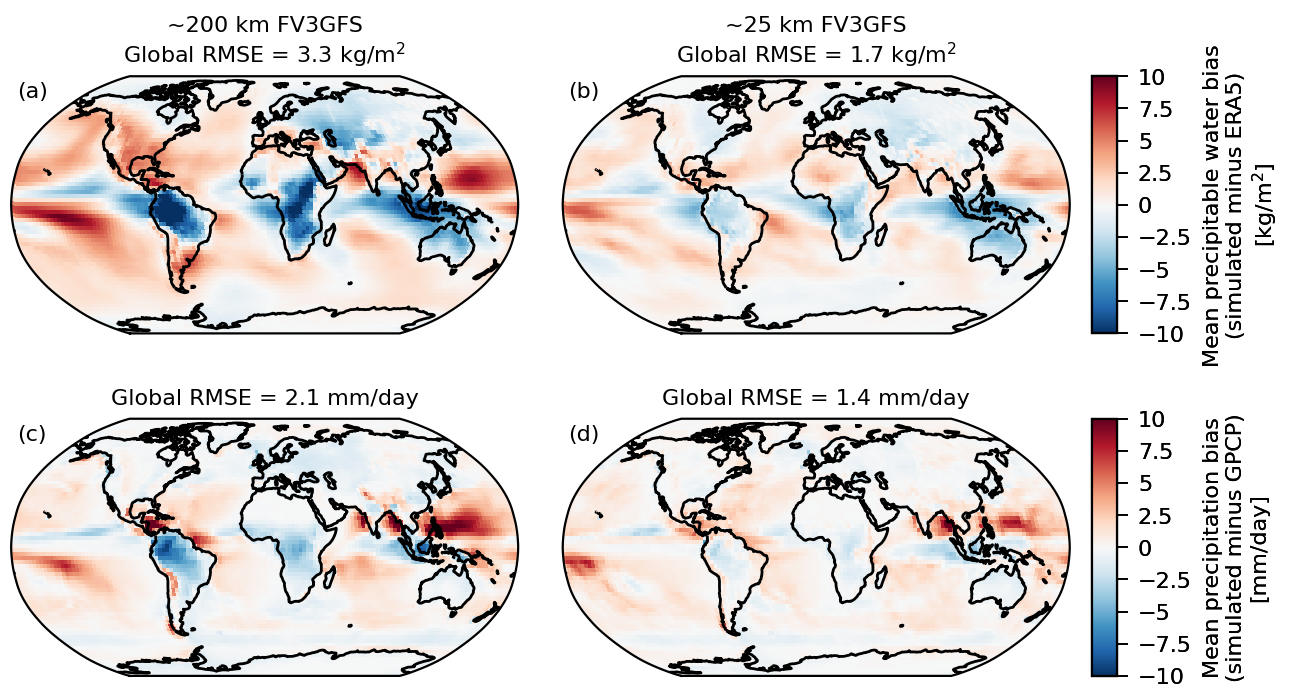

In [8]:
fig, axes = proplot.subplots(ncols=2, nrows=2, proj="robin", figwidth=6.5, refaspect=2., pad=2)

for ax, configuration in zip(axes, bias.configuration):
    p1 = bias.PWAT.sel(configuration=configuration).plot(ax=ax, vmin=-10, vmax=10, cmap="RdBu_r", add_colorbar=False, discrete=False)
    ax.coastlines()
    
axes[0].set_title(f"~200 km FV3GFS\nGlobal RMSE = {rmse.PWAT.sel(configuration='baseline').item():0.1f} kg/m$^2$")
axes[1].set_title(f"~25 km FV3GFS\nGlobal RMSE = {rmse.PWAT.sel(configuration='fine-resolution').item():0.1f} kg/m$^2$")
axes[0].annotate("(a)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
axes[1].annotate("(b)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

for ax, configuration in zip(axes[2:], bias.configuration):
    p2 = bias.total_precipitation_rate.sel(configuration=configuration).plot(ax=ax, vmin=-10, vmax=10, cmap="RdBu_r", add_colorbar=False, discrete=False)
    ax.coastlines()
    
axes[2].set_title(f"Global RMSE = {rmse.total_precipitation_rate.sel(configuration='baseline').item():0.1f} mm/day")
axes[3].set_title(f"Global RMSE = {rmse.total_precipitation_rate.sel(configuration='fine-resolution').item():0.1f} mm/day")
axes[2].annotate("(c)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
axes[3].annotate("(d)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

fig.colorbar(
    p1,
    rows=[1],
    loc="right",
    width=0.125,
    label="Mean precipitable water bias\n(simulated minus ERA5)\n[kg/m$^2$]"
)

fig.colorbar(
    p2,
    rows=[2],
    loc="right",
    width=0.125,
    label="Mean precipitation bias\n(simulated minus GPCP)\n[mm/day]"
)

fig.savefig("figures/figure-01.png", dpi=200)
fig.savefig("figures/figure-01.pdf")